Statisticians only measure how much they have lost. They consider their wins as *negative losses*. What's interesting is how they measure their losses.

> A meteorologist is predicting the probability of a possible hurricane striking his city. He estimates, with 95% confidence, that the probability of it not striking is between 99% - 100%. He is very hapy with his precision and advises the city that a major evacuation is unnecessary. Unfortunately, the hurricane does strike and the city is flooded.

## Loss Functions

A loss function is a function of the true parameter, and an estimate of that parameter

$$L(\theta, \hat{\theta}) = f(\theta, \hat{\theta})$$

The loss function measures how *bad* our current estimate is: the larger the loss, the worse the estimate is according to the loss function. A simple, and very common, example of loss function is the *squared-error loss*:

$$ L(\theta, \hat{\theta}) = (\theta - \hat{\theta})^2 $$

The squared-error loss function is used in estimators like linear regression, UMVUEs and many areas of machine learning. We can also consider an asymmetric squared-error loss function, something like:

$$
L(\theta, \hat{\theta}) = 
\begin{cases}
(\theta - \hat{\theta})^2 & \hat{\theta} < \theta \\
c(\theta - \hat{\theta})^2 & \hat{\theta} \ge \theta, \; 0 < c < 1
\end{cases}
$$

which represents that estimating a value larger than the true estimate is preferable to estimating a value below. A situation where this might be useful is in estimating web traffic for the next month, where an over-estimated outlook is preferred so as to avoid an underallocation of server resources.

A negative property about the squred-error loss is that it puts a disproportionate emphasis on large outliers.

A more *robust loss function* that increases linearly with the difference is the *absolute-loss*

$$ L(\theta, \hat{\theta}) = |\theta - \hat{\theta}| $$

Loss functions are motivated by

1. Mathematical convenience
2. They are robust to application

## Loss functions in real world

$P(\theta|X)$ is the posterior distribution of $\theta$ after observing data $X$, then the following function is understandable as the *expected loss of choosing estimate $\hat{\theta}$ to estimate $\theta$:

$$ l(\hat{\theta}) = E_\theta[L(\theta, \hat{\theta}] $$

This is also known as the *risk* of estimate $\hat{\theta}$. We can approximate the expected loss of using estimate $\hat{\theta}$ by the Law of Large Numbers:

$$ \frac{1}{N} \sum_{i=1}^N L(\theta_i, \hat{\theta}) \approx E_\theta \Big[ L(\theta, \hat{\theta} \Big] = l(\hat{\theta}) $$

#### Example: Optimizing for the Showcase on the Price is Right

Game rules:

1. Two contestants compete in the ShowCase
2. Each contestant is shown a unique suite of prizes
3. AFter the viewing, the contestants are asked to bid on the price for their unique suite of prizes.
4. If a bid price is over the actual price, the bid's owner is disqualified from winning.
5. If a bid price is under the tru price by less than \$250, the winner is awarded both prizes.

The difficulty in the game is balancing your uncertainty in the prices, keeping your bid low enough so as to not bid over, and trying to bid close to the price.

Suppose we have recorded the Showcases from previous *The Price is Right* episodes and have *prior beliefs about what distribution the tru price follows. For simpliity, suppose it follows a Normal:

$$ \text{True Price} \sim \text{Normal }(\mu_p, \sigma_p)$$

For now, we will assume $\mu_p = 35000$ and $\sigma_p = 7500$

Let's suppose your beliefs about the prices of prizes also follow Normal distributions:

$$ \text{Prize}_i \sim \text{Normal }(\mu_i, \sigma_i) $$

We can specify what we think a fair price is through the $\mu_i$, and express uncertainty of our guess in the $\sigma_i$.

The true price of the prize suite is given by $\text{Prize}_1 + \text{Prize}_2 + \epsilon$, where $\epsilon$ is some error term.

Let make some values concrete. We observed prize suite:

1. A trip to wonderful Toronto, Canada!
2. A lovely new snowblower!

WE have some guesses about the tru prices of these objects, but we are also pretty uncertain about them.

$$
\text{snowblower } \sim \text{ Normal}(3000, 500) \\
\text{Toronto } \sim \text{ Normal}(12000, 3000)
$$

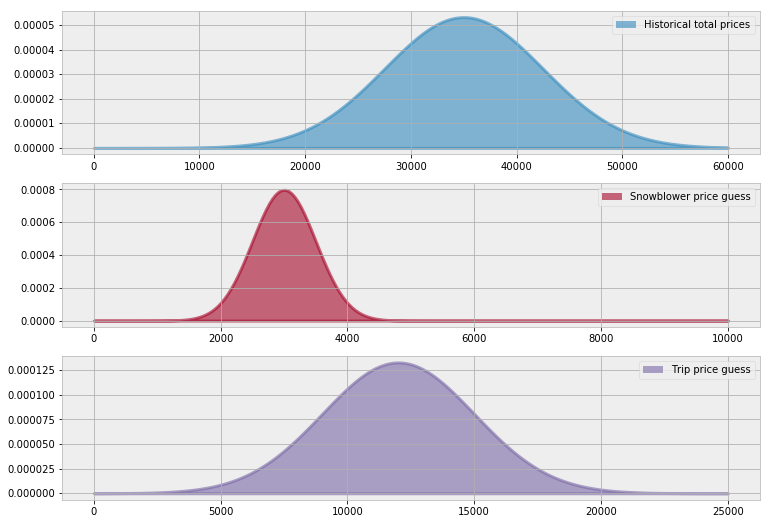

In [8]:
figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500), 
                       color="#348ABD", lw=3, alpha=.6, 
                       label="Historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500), 
                       color="#A60628", lw=3, alpha=.6, 
                       label="Snowblower price guess")
p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000), 
                       color="#7A68A6", lw=3, alpha=.6, 
                       label="Trip price guess")
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);


In [11]:
data_mu = [3000, 12000]
data_std = [500, 200]

mu_prior = 35000
std_prior = 7500

with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize1 = pm.Normal("prize1", mu=data_mu[0], sd=data_std[0])
    prize2 = pm.Normal("prize2", mu=data_mu[1], sd=data_std[1])
    
    price_estimate = prize1 + prize2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3000)).logp(true_price)
    error = pm.Potential("error", logp)
    
    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]
    
price_trace = burned_trace["true_price"]
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:08<00:00, 5639.05it/s]


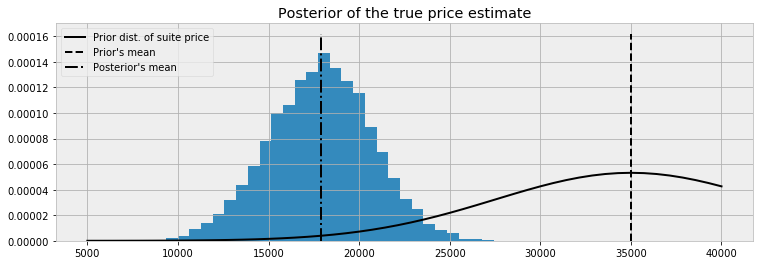

In [14]:
figsize(12.5, 4)

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2, label="Prior dist. of suite price")
_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")

plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="Prior's mean", linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), label="Posterior's mean", linestyles="-.")
plt.legend(loc="upper left");

A frequentist, seeing the 2 prizes and having the same beliefs about their prices, would bid $\mu_1 + \mu_2 = 35000$, regardless of any uncertainty. The *naive Bayesian* would simply pick the mean of the posterior distribution. But we have more information about our eventual outcomes; we should incorporate this into our bid. We will use the loss function above to find the *best* bid.

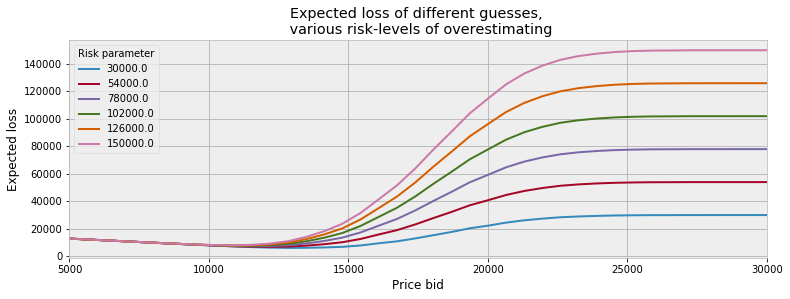

In [16]:
def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(guess - true_price[~ix])
    close_mask = [abs(true_price - guess) <= 250]
    loss[close_mask] = -2 * true_price[close_mask]
    loss[ix] = risk
    return loss

guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="{}".format(_p))
    
plt.title("Expected loss of different guesses, \n various risk-levels of overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("Price bid")
plt.ylabel("Expected loss")
plt.xlim(5000, 30000);

### Minimizing our losses

We would like to minimize our expected loss by finding the solution to

$$ \text{argmin }_\hat{\theta} E_\theta \Big[ L(\theta, \hat{\theta}) \Big] $$

The minimum of the expected loss is called *Bayes action*. We will use `fmin` function to find a minimum.

Minimum at risk 30000: 13172.36
Minimum at risk 54000: 12050.15
Minimum at risk 78000: 11545.10
Minimum at risk 102000: 11069.55
Minimum at risk 126000: 11048.63
Minimum at risk 150000: 10694.57


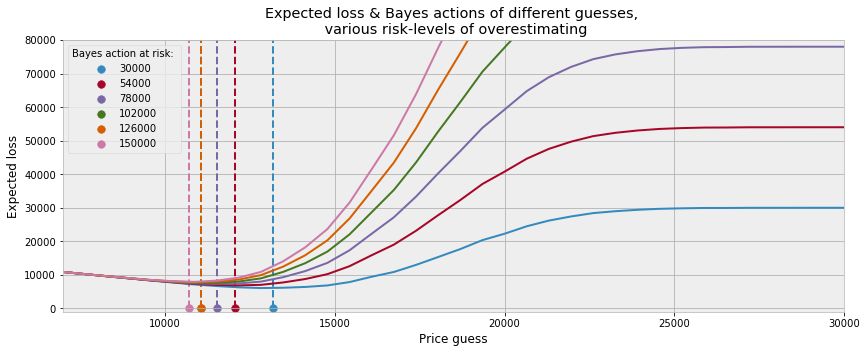

In [18]:
import scipy.optimize as optim

figsize(14, 5)
ax = plt.subplot(111)

for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = optim.fmin(expected_loss, 15000, args=(_p,), disp=False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s=60, color=_color['color'], label="%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("Minimum at risk %d: %.2f" % (_p, _min_results))
    
plt.title("Expected loss & Bayes actions of different guesses, \n various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk: ")
plt.xlabel("Price guess")
plt.ylabel("Expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

### Shortcuts

For some loss functions, the Bayes action is known in closed form

* If using the mean-squared loss, the Bayes action is the mean of the posterior distribution, i.e. the value $E_\theta[\theta]$ minimizes $E_\theta \Big[ (\theta - \hat{\theta})^2 \Big]$
* The *median* of the posterior distribution minimizes the expected absolute-loss. The sample median of the posterior samples is an appropriate and very accurate approximation to the true median.

## Machine Learning via Bayesian Methods

#### Example: Financial prediction

Suppose the future return of a stock price is 0.01 (1%). We need a loss function that take into account the *sign* of the prediction and true value.

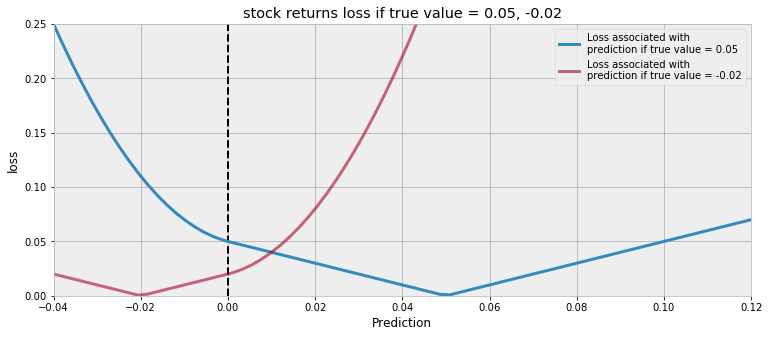

In [10]:
figsize(12.5, 5)
def stock_loss(true_return, yhat, alpha = 100.):
    if true_return * yhat < 0:
        return alpha * yhat **2 - np.sign(true_return)*yhat + abs(true_return)
    else:
        return abs(true_return - yhat)
    
true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], 
         label = "Loss associated with \nprediction if true value = 0.05", lw = 3)
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("Prediction")
plt.ylabel("loss")
plt.xlim(-.04, .12)
plt.ylim(0, .25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = .6, 
         label = "Loss associated with \nprediction if true value = -0.02", lw = 3)
plt.legend()
plt.title("stock returns loss if true value = 0.05, -0.02");

We will perform a regression on a trading signal that we believe predicts future returns well. Our dataset is artificial, as most financial data is not even close to linear.

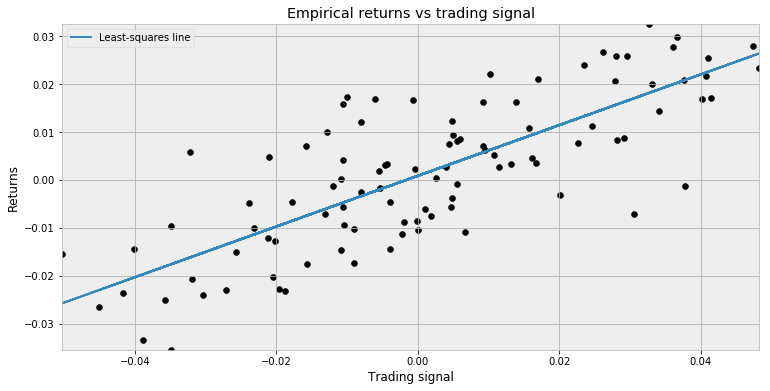

In [38]:
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0, 1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("Trading signal")
plt.ylabel("Returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label="Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

We perform a simple Bayesian linear regression on this dataset. We look for a model:

$$ R = \alpha + \beta x + \epsilon $$

Where $\alpha, \beta$ are our unknown parameters and $\epsilon \sim \text{Normal }(0, \sigma)$. The most common priors on $\beta$ and $\alpha$ are Normal priors. We assign a prior on $\sigma$, so that $\sigma$ is uniform over 0 to 100.

In [39]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4726.40it/s]


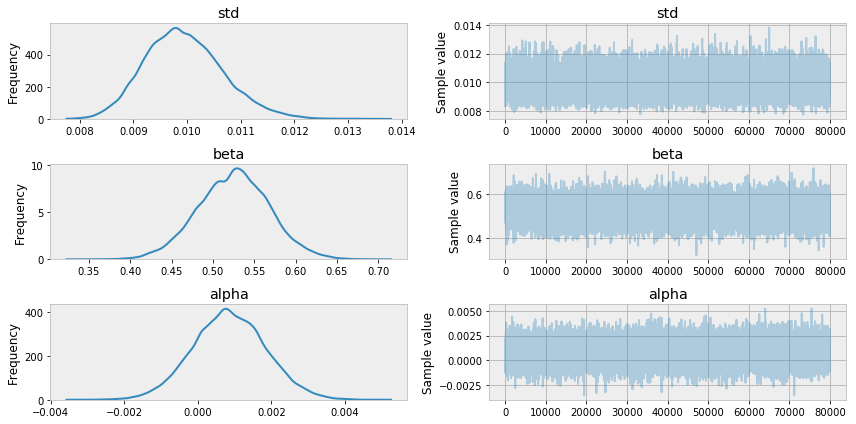

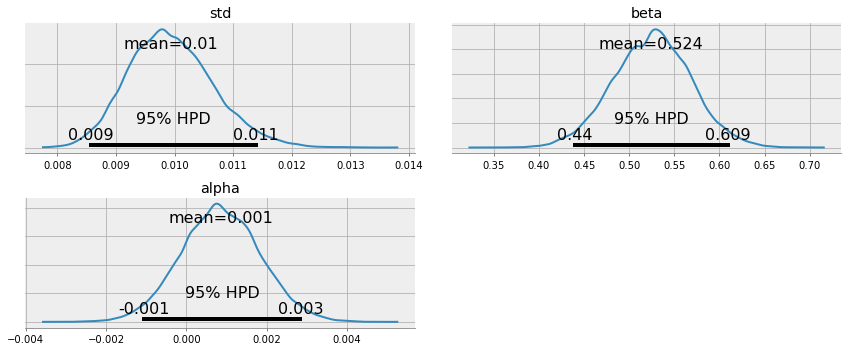

In [40]:
pm.plots.traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"])
pm.plot_posterior(trace=burned_trace, varnames=["std", "beta", "alpha"], kde_plot=True);

For a specific trading signal, call it $x$, the distribution of possible returns has the form:

$$ R_i(x) = \alpha_i + \beta_i x + \epsilon$$

where $\epsilon \sim \text{Normal }(0, \sigma_i)$, and $i$ indexes our posterior samples. We wish to find the solution to 

$$ \text{argmin }_r E_{R(x)}[L(R(x), r)]$$

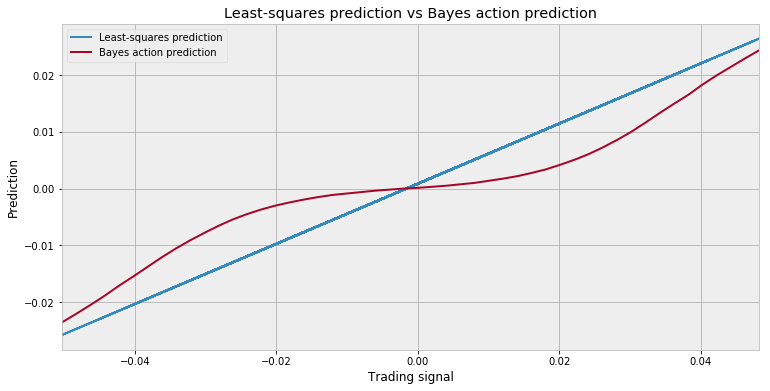

In [42]:
figsize(12.5, 6)
from scipy.optimize import fmin

def stock_loss(price, pred, coef=500):
    sol = np.zeros_like(price)
    ix = price*pred < 0
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples * signal + noise

opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcome = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcome, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)
    
plt.xlabel("Trading signal")
plt.ylabel("Prediction")
plt.title("Least-squares prediction vs Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left");

when the signal is near 0, and many of the possible returns outcomes are possibly, both positive and negative, our best prediction is to predict close to 0, hence *take no position*. The sparse-prediction model is not trying to *fit* the data the best. It is trying to find the best prediction with *respect* to our stock_loss defined loss.

In [3]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import pymc3 as pm

from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()